## Importing libraries
---------------

In [131]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from functools import reduce

## Reading Files
---------------

In [132]:
# Finding CABRa attributes csv files
path_files = pathlib.Path('CABRa_attributes_csv/')
cabra_attributes_files = path_files.rglob('*.csv')

In [133]:
# Reading files
dfs = []
for file in cabra_attributes_files:
    print(file)
    df = pd.read_csv(file, engine='python', delimiter=';')
    dfs.append(df)

CABRa_attributes_csv\CABra_dataset _Additional_attributes.csv
CABRa_attributes_csv\CABra_dataset _Climate_attributes.csv
CABRa_attributes_csv\CABra_dataset_Groundwater_attributes.csv
CABRa_attributes_csv\CABra_dataset_Hydrologic_disturbance_attributes.csv
CABRa_attributes_csv\CABra_dataset_Land_cover_attributes.csv
CABRa_attributes_csv\CABra_dataset_Streamflow_attributes.csv
CABRa_attributes_csv\cabra_general_attributes.csv
CABRa_attributes_csv\cabra_Geology_attributes.csv
CABRa_attributes_csv\CABra_soil_attributes.csv
CABRa_attributes_csv\CABra_topography_attributes.csv


## Creating Dataset and calculating variables
-----------------------

In [4]:
# Merging DataFrames
df_merged = reduce(lambda  left,right: pd.merge(left, right, on=['CABra ID', 'ANA ID'], how='outer'), dfs)

In [5]:
df_merged.head()

,CABra ID,ANA ID,longitude_centroid,latitude_centroid,dist_coast,clim_p,clim_tmin,clim_tmax,clim_rh,clim_wind,...,soil_carbon,soil_bulk,soil_depth,catch_area,elev_mean,elev_min,elev_max,elev_gauge,catch_slope,catch_order
0,1,13880000,-68.028,-8.989,1407.55,5.64,21.61,30.48,83.17,0.82,...,34.439,25.456,1.335,243.410.279,178.97,44.65,564.03,44.65,3.14,7
1,2,14110000,-66.695,2.016,1009.09,8.88,21.83,28.60,86.41,0.42,...,21.926,17.609,1.256,76.898.617,222.97,80.40,2892.44,80.40,4.72,6
2,3,14230000,-68.936,1.573,1009.70,8.52,22.18,29.67,85.71,0.60,...,23.241,20.530,1.219,24.018.785,151.47,80.86,952.20,80.86,2.81,4
3,4,14250000,-67.305,1.734,1095.42,8.86,22.00,29.13,86.26,0.49,...,22.725,18.612,1.235,127.540.913,184.31,74.32,2892.44,74.32,3.71,6
4,5,14260000,-70.894,1.201,964.52,7.79,21.91,28.80,85.44,0.67,...,22.066,20.859,1.248,41.762.638,206.08,85.09,615.36,85.09,2.30,5


In [6]:
# All CABRa attributes files
df_merged.columns

Index(['CABra ID', 'ANA ID', 'longitude_centroid', 'latitude_centroid',
       'dist_coast', 'clim_p', 'clim_tmin', 'clim_tmax', 'clim_rh',
       'clim_wind', 'clim_srad', 'clim_et', 'clim_pet', 'aridity_index',
       'p_seasonality', 'clim_quality', 'aquif_name', 'aquif_type',
       'catch_wtd', 'catch_hand', 'hand_class', 'dist_urban', 'cover_urban_x',
       'cover_crops_x', 'res_number', 'res_area', 'res_volume',
       'res_regulation', 'water_demand', 'hdisturb_index', 'cover_main',
       'cover_bare', 'cover_forest', 'cover_crops_y', 'cover_grass',
       'cover_moss', 'cover_shrub', 'cover_urban_y', 'cover_snow',
       'cover_waterp', 'cover_waters', 'ndvi_djf', 'ndvi_mam', 'ndvi_jja',
       'ndvi_son', 'q_mean', 'q_1', 'q_5', 'q_95', 'q_99', 'q_lf', 'q_ld',
       'q_hf', 'q_hd', 'q_hfd', 'q_zero', 'q_cv', 'q_lcv', 'q_hcv',
       'q_elasticity', 'fdc_slope', 'baseflow_index', 'runoff_coef',
       'longitude', 'latitude', 'gauge_hreg', 'gauge_biome', 'gauge_state',
    

In [7]:
# Calculating ECI (Liu et al. (2020))
# Aparently there is a Warning
df_merged['ECI'] = np.log10(df_merged['q_mean']/(df_merged['clim_p']-df_merged['clim_et']))

C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# There is one bad ID
# log(0) => Erro
df_merged.loc[df_merged['ECI'].isnull(),['ECI', 'q_mean', 'clim_p', 'clim_et']]

,ECI,q_mean,clim_p,clim_et
686,NaN,0.03,1.64,1.66


In [9]:
# Calculating the ratio Effective Area / Topographic Area (Liu et al. (2020))
df_merged['Aeff/Atopo'] = df_merged['q_mean']/(df_merged['clim_p']-df_merged['clim_et'])

In [10]:
# Checking ECI and Ratio
df_merged[['Aeff/Atopo','ECI']].describe()

,Aeff/Atopo,ECI
count,735.000000,734.000000
mean,1.033062,-0.024864
std,0.472764,0.200450
min,-1.500000,-0.989005
25%,0.812509,-0.089254
50%,1.006250,0.002825
75%,1.196199,0.077825
max,6.781955,0.831355


In [134]:
# Creating new column called 'substantial' and grouping into 3 groups
# The ratio is according to Liu et al. (2020)
max_ratio = 2
min_ratio = 0.5

df_merged.loc[df_merged['Aeff/Atopo']>=max_ratio, 'substantial'] = 'Gaining'
df_merged.loc[(df_merged['Aeff/Atopo']<max_ratio)&
              (df_merged['Aeff/Atopo']>1), 'substantial'] = 'Small gain'
df_merged.loc[(df_merged['Aeff/Atopo']>min_ratio)&
              (df_merged['Aeff/Atopo']<=1), 'substantial'] = 'Small loss'
df_merged.loc[df_merged['Aeff/Atopo']<=min_ratio, 'substantial'] = 'Losing'

In [135]:
# Intervals using ECI values

max_ratio_eci = 0.113943
min_ratio_eci = -0.1549
df_merged.loc[df_merged['ECI']>= max_ratio_eci,'substantial_eci'] = 'Gaining'
df_merged.loc[(df_merged['ECI']<max_ratio_eci)&
              (df_merged['ECI']>0), 'substantial_eci'] = 'Small gain'
df_merged.loc[(df_merged['ECI']>min_ratio_eci)&
              (df_merged['ECI']<=0), 'substantial_eci'] = 'Small loss'
df_merged.loc[df_merged['ECI']<=min_ratio_eci, 'substantial_eci'] = 'Losing'

In [13]:
df_merged['ECI'].describe()

count    734.000000
mean      -0.024864
std        0.200450
min       -0.989005
25%       -0.089254
50%        0.002825
75%        0.077825
max        0.831355
Name: ECI, dtype: float64

In [14]:
# The column 'catch_area' is problematic, because it was a object type.
# Changed to 'int'
df_merged['catch_area'] = df_merged['catch_area'].str.replace('.','')
df_merged['catch_area'] = df_merged['catch_area'].astype('int64')

In [15]:
# List of relevant variables
variables = ['aridity_index', 'catch_area','catch_slope','sub_permeability','elev_mean', 'dist_coast','res_area','hdisturb_index','catch_hand']

In [16]:
# Checking the variables
df_merged[variables].describe()

,aridity_index,catch_area,catch_slope,sub_permeability,elev_mean,dist_coast,res_area,hdisturb_index,catch_hand
count,735.000000,7.350000e+02,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000
mean,1.382517,4.482785e+07,11.661061,-13.439937,672.380694,362.882014,0.283782,0.076993,97.300122
std,0.562587,2.385873e+08,7.482936,0.580853,290.669305,325.772133,0.513944,0.093201,70.664237
min,0.550000,8.553000e+03,0.670000,-15.645000,47.790000,3.020000,0.000000,0.000000,14.113000
25%,1.000000,8.508350e+05,5.780000,-13.810500,461.485000,102.375000,0.020000,0.020000,54.406500
50%,1.250000,2.886341e+06,9.230000,-13.328000,695.290000,265.700000,0.090000,0.050000,75.027000
75%,1.510000,1.281423e+07,17.250000,-13.000000,863.635000,522.110000,0.275000,0.100000,117.702500
max,4.190000,4.807564e+09,35.560000,-12.243000,1718.580000,1472.920000,5.560000,0.630000,631.161000


In [17]:
df_merged['gauge_biome'].unique()

array(['               Amazon', '              Cerrado',
       '             Caatinga', '      Atlantic forest',
       '             Pantanal', '                Pampa'], dtype=object)

## Plotting
-----------------------

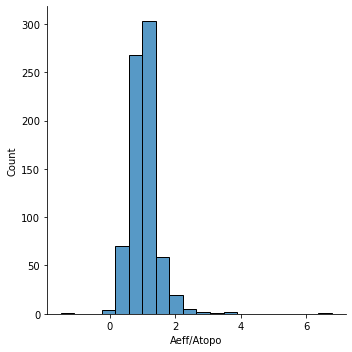

In [19]:
# Checking the distribution of the ratio
# Apparently there is at least one catchment with strange ratios (need to investigate)
sns.displot(df_merged, x='Aeff/Atopo', bins=20)

In [143]:
plot_variables = ['aridity_index', 'catch_slope','p_seasonality','elev_mean','catch_wtd','catch_hand']
label_variables = ['Aridity Index', 'Catch Slope', 'P seasonality','Elevation mean','Catch water table depth','Catch HAND']

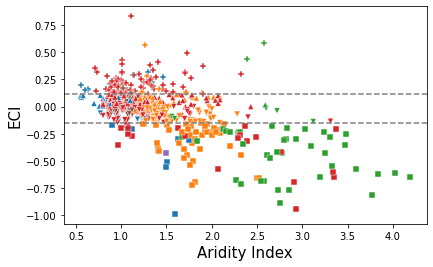

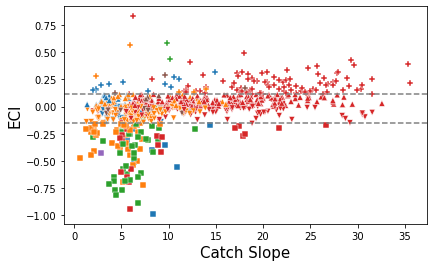

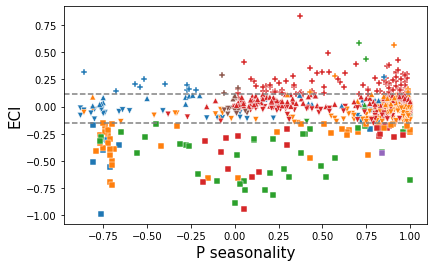

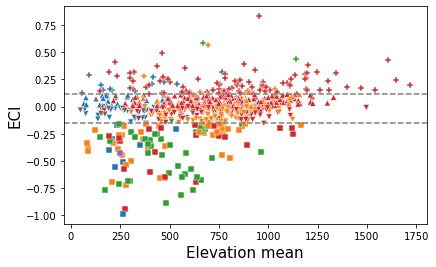

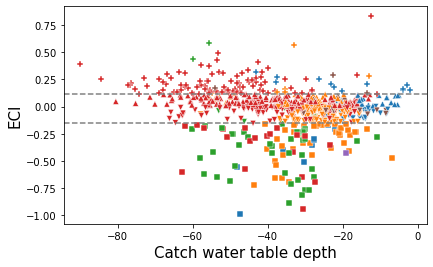

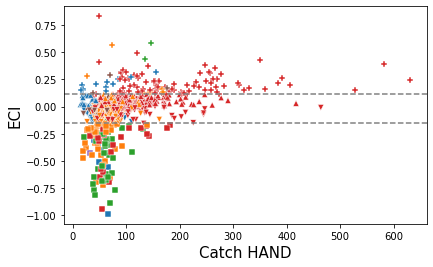

In [144]:
# Plot and looping throught the variables
azul_escuro = '#0906E2'
azul_claro = '#818BC2'
vermelho_escuro = '#B80203'
vermelho_claro = '#F0C6C9'

for variable, xlabel in zip(plot_variables, label_variables):
    plt.figure(figsize=(6.5,4))

    ax = sns.scatterplot(x=variable, y='ECI',
    #                      hue='substantial_eci',
                         hue='gauge_biome',
                         style='substantial_eci',
                         data=df_merged, 
                         markers=['^','P','v','s'],
    #                      palette=[azul_claro,azul_escuro ,vermelho_claro, vermelho_escuro],
                         alpha=1,
                        )

    ax.axhline(max_ratio_eci, ls='--',color='gray')
    ax.axhline(min_ratio_eci, ls='--',color='gray')
    ax.tick_params(labelsize=10)
    ax.set_xlabel(f'{xlabel}', fontsize=15)
    ax.set_ylabel('ECI', fontsize=15)

    plt.legend([],[], frameon=False)

    # ax.figure.savefig(f'{variable}_eci.png', dpi=300)
    # ax.figure.savefig(f'{variable}_eci_biome.png', dpi=300)
    # ax.figure.savefig(f'{variable}_eci_biome_gl.png', dpi=300)
    